<a href="https://colab.research.google.com/github/khigashi1987/Hi-C_handson/blob/master/Hi_C_analysis_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hi-C解析実習

  [HiCExplorer](https://hicexplorer.readthedocs.io)パイプラインでHi-C実験データの解析をしてみる。  

## 0. HiCExplorerのインストール

HiCExplorerはpipとcondaでインストールできる...はずだったが、HiCExplorerがpipのサポートを切ってしまった...   

以下のようにcondaでインストールすることが推奨されている。

しかしGoogle Colaboratoryでconda環境がうまく動かなかったので、ここではpipを使って古いバージョンのHiCExplorerを使うことにする。実際に解析をするときは、condaを強く推奨。

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install pyfaidx

In [ ]:
req = '''
ipykernel >= 5.3.0
pysam >= 0.16.*
intervaltree >= 3.1.*
biopython
tables >= 3.6.*
pandas >= 1.1.*
pybigwig >= 0.3.*
jinja2 >= 2.11
unidecode >= 1.1.*
hicmatrix
hic2cool
psutil >= 5.7.*
pygenometracks >= 3.5
cooler
krbalancing
pybedtools >= 0.8.*
future >= 0.18
tqdm >= 4.50
hyperopt >= 0.2.4
scikit-learn >= 0.23.2
imbalanced-learn >= 0.7.*
cleanlab >= 0.1.*
'''

with open('./requirements.txt', 'w') as ofp:
    ofp.write(req)

In [ ]:
!pip install -r ./requirements.txt

In [ ]:
!pip install hicexplorer

In [ ]:
!git clone https://github.com/khigashi1987/Hi-C_handson.git

In [9]:
%cd ./Hi-C_handson/

/content/Hi-C_handson


## 1. データのダウンロード

扱うデータは、[Wibke Schwarzer, Nezar Abdennur, Anton Goloborodko, et al. Nature (2017)](https://www.nature.com/articles/nature24281)（以下、Schwarzer2017）。  
この論文では、コヒーシンの染色体高次構造形成への影響を調べるため、コヒーシンをクロマチンにロードする役割を持つNIPBLを欠損させたマウスの肝細胞でHi-Cを行なっている。   
コヒーシンが染色体から外れてしまっているので、構造はだいぶ異なるはず。   
この実習では、（ほんとはfloxと比較すべきだけど）野生型とΔNipblで染色体構造がどのように異なるか、それと、論文の図を再現できるかを、公共データベースに公開されているシーケンスデータから自分で解析して確かめてみる。   


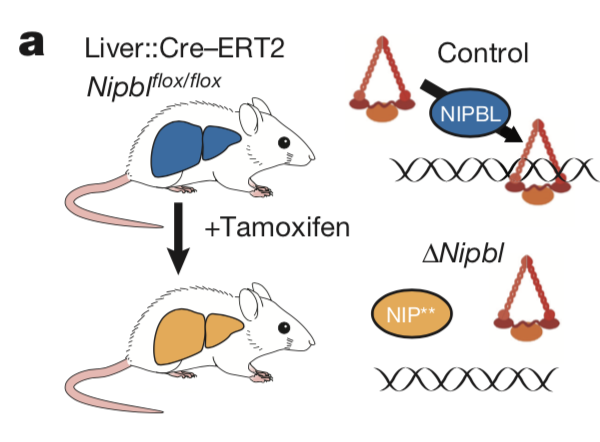

In [19]:
from IPython.display import Image
Image('data/images/experimental_design.png', width=400)
# 　Schwarzer2017, Fig.1より

まずはデータのダウンロード。  
WTのサンプルである**SRR5168118**, ΔNipblサンプルである**SRR5168150**それぞれについて、以下のようにしてEMBL-EBI ENAからデータを取ってくる。  
（fastq-dumpでもいいが個人的にはENAの方が探しやすいしなんか安心感があって好き）   
  
実際はそれぞれのサンプル数億本のリード数（x 複数レプリケイト）だが、実習の時間的環境的都合上、ここで扱うのはそのほんの一部（SRR5168118: 18,063,305本、SRR5168150: 17,105,434本）のみ。  
Hi-C解析はリード数が結果の解像度に直結するので、数千万本程度だと、かなり粗い結果しか得られないことに注意。

In [ ]:
%%bash
<< SKIP # 実習ではダウンロード済み
wget -O SRR5168118_1.fastq.gz ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR516/008/SRR5168118/SRR5168118_1.fastq.gz
wget -O SRR5168118_2.fastq.gz ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR516/008/SRR5168118/SRR5168118_2.fastq.gz

wget -O SRR5168150_1.fastq.gz ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR516/000/SRR5168150/SRR5168150_1.fastq.gz
wget -O SRR5168150_2.fastq.gz ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR516/000/SRR5168150/SRR5168150_2.fastq.gz
SKIP

## 2. マッピング

マウスのデータなので、mm10（[GRCm38](https://www.ncbi.nlm.nih.gov/assembly/GCF_000001635.20/)）ゲノム配列にマッピングする。  
他のXX-seqデータと違って、Hi-C解析に特有の注意点がいくつかある。  
+ マッパーによっては、ペアエンドファイルを入力するとインサートサイズを適当に仮定してすばやく検索するヒューリスティックが起動してしまう。Hi-Cデータの場合ペアはゲノム上ですごく遠い場所（あるいは別の染色体）に由来するかもしれない。なので、R1とR2は個別にマッピングする。
+ ローカルアラインメントをする。グローバルアラインメントはダメ。Hi-Cリードは本質的にligation productで、chimeric sequenceなため。
+ アラインメントのパラメータを適切に調整する。HiCExplorerでは、BWAマッピングの場合は以下が推奨されている。
    - -A1 マッチスコア。1に設定（デフォルト）
    - -B4 ミスマッチペナルティ。4に設定（デフォルト）
    - -O6 ギャップ開始ペナルティ。6に設定（デフォルト）
    - -E50 ギャップ伸長ペナルティ。デフォルトは1だが、ずっと大きく50にする。
    - -L0 クリッピングペナルティ。5'側あるいは3'側にSmith-Watermanのスコア計算を伸ばしていって、ベストスコアのところで止めるか端っこまで到達させるかを調整するペナルティ。これが大きいとグローバルアラインメントになりやすい。デフォルトは5だが、これをゼロに設定。
    - 以上の設定にすればローカルアラインメントが得られやすくなる。

In [ ]:
%%bash
<< SKIP #マッピングも時間の関係で省略
datadir=data
reffile=mm10.fa

bwa index ${reffile}

for srr_id in "SRR5168118" "SRR5168150"
do
    echo $srr_id
    infile_1=${datadir}/${srr_id}_1.fastq.gz
    infile_2=${datadir}/${srr_id}_2.fastq.gz
    bwa mem -A1 -B4  -E50 -L0 $reffile \
        $infile_1 2>> ${srr_id}.r1.log | samtools view -Shb - > ${datadir}/${srr_id}_R1.bam
    bwa mem -A1 -B4  -E50 -L0 $reffile \
        $infile_2 2>> ${srr_id}.r2.log | samtools view -Shb - > ${datadir}/${srr_id}_R2.bam
done
SKIP

## 3. リードのフィルタリングとコンタクトマップの構築

マッピングされたペアのすべてがHi-Cのコンタクト情報として使えるわけではない。  
以下のように様々な理由で「コンタクト」を反映していないペアが存在する。  
不適切なペアは、マッピングのパターン、すなわちマッピングされたStrand（= orientation）や、実験に使った制限酵素の認識配列の位置との関係などから判断することができる。 

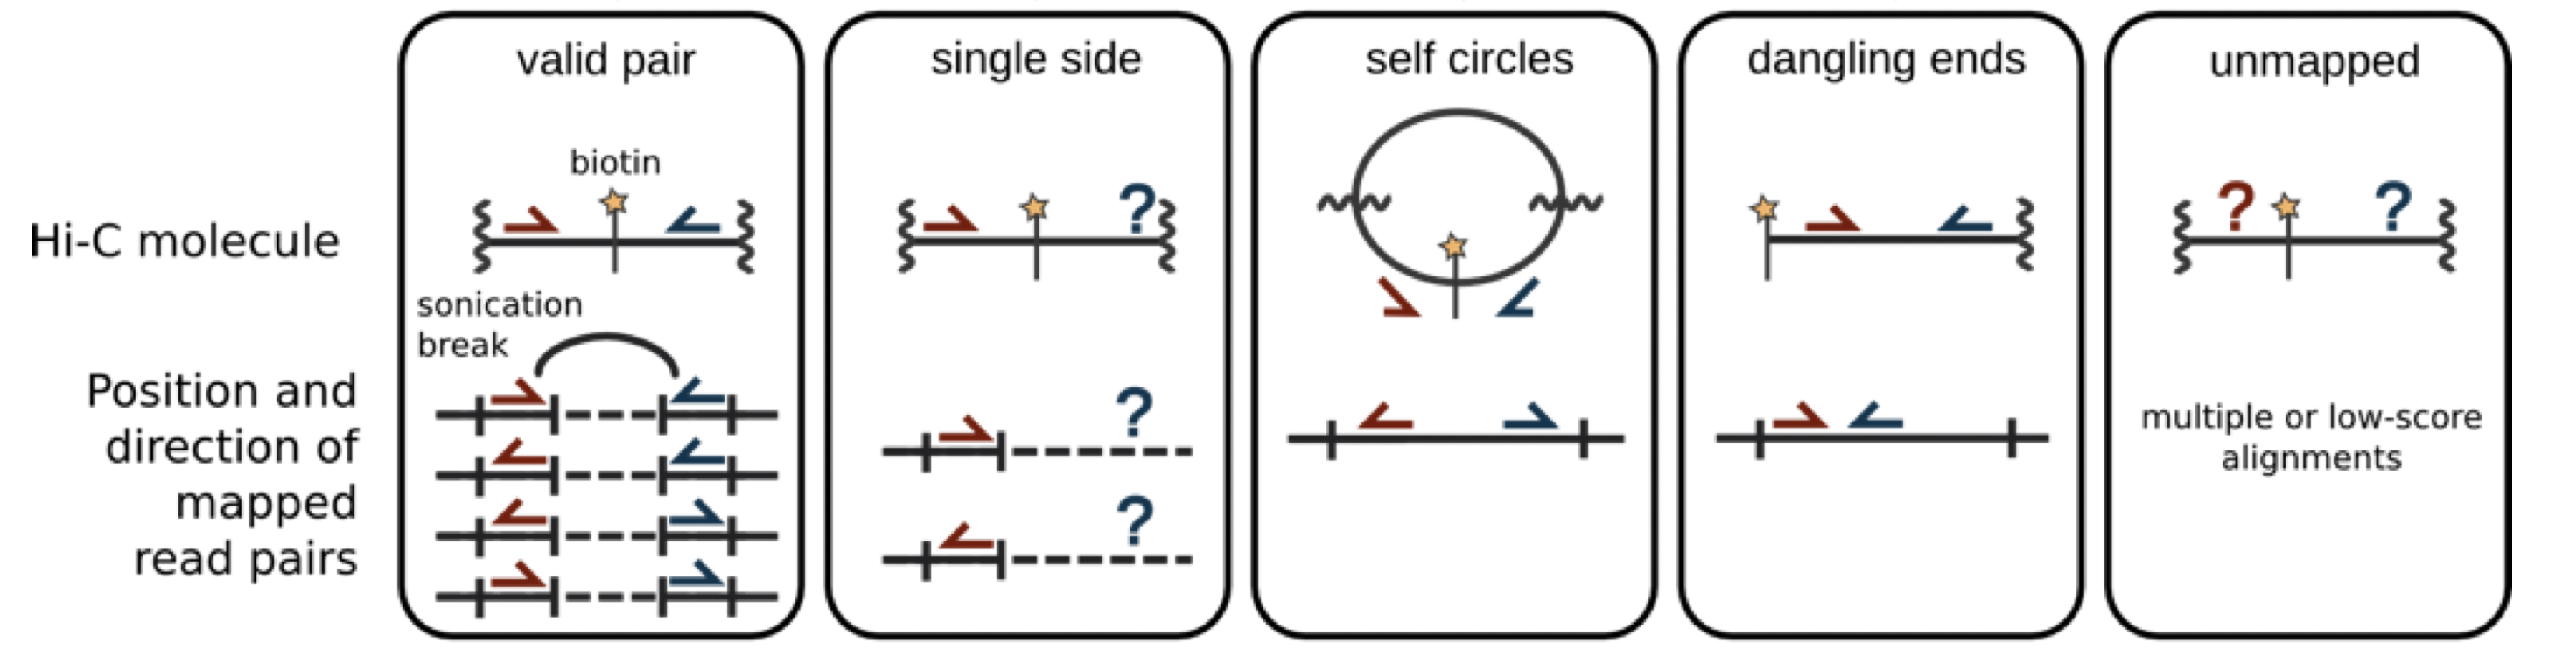

In [18]:
Image('data/images/pair_mapping_patterns.png', width=800)
# 　Imakaev, Maxim, et al. "Iterative correction of Hi-C data reveals hallmarks of chromosome organization.” Nature methods 9.10 (2012): 999-1003.より

そこで、R1.bam, R2.bamから、valid-pairの情報のみを抽出し、さらに指定した解像度（Binサイズ）でマッピングの位置情報を集計する。  
それを一気にやってくれるのが HiCExplorer の ```hicBuildMatrix``` コマンド。

In [ ]:
%%bash
<< SKIP #このプロセスも、数ギガバイトのbamファイルをダウンロードさせるのがきつかったのでスキップ。実際に計算するのは次から。
outdir=data/build_matrix
for srr_id in "SRR5168118" "SRR5168150"
do
    echo $srr_id
    infile_1=data/${srr_id}_R1.bam
    infile_2=data/${srr_id}_R2.bam

    qcdir=${outdir}/${srr_id}_qc
    outfile=${outdir}/${srr_id}_100kb.h5
    hicBuildMatrix --samFiles ${infile_1} ${infile_2} \
        --binSize 100000 \ 
        --restrictionSequence AAGCTT  \
        --danglingSequence AGCT \
        --outFileName ${outfile} \
        --QCfolder ${qcdir_name} \
        --threads 32
done
SKIP

# --binSize
## コンタクトマップのBinサイズ。この実習ではリード数がめっちゃ少ないので100kbpの粗い解像度。
## 制限酵素認識配列の位置情報をbedファイルで与えることで、
## 制限断片の解像度（不定Binサイズ）＝理論上最大の解像度のマップを作ることもできる。
# --restrictionSequence
## 制限酵素認識配列。ここでは、元論文読むとHindIII処理していたので、その認識配列。実験によって異なる。
# --danglingSequence
## 制限消化したときの突出末端の配列。HindIIIの場合はAGCT。
# --outFileName
## 結果のコンタクトマップ。デフォルトではHDF5フォーマットで出力される。
# --QCfolder
## クオリティ情報をまとめて出してくれる。そのディレクトリを指定。
# --threads
## 計算環境に合わせて適切に...

設定したQCディレクトリにさまざまな統計情報を出力してくれている。

In [21]:
!ls data/build_matrix/SRR5168118_qc/

distance.png	     pairs_sequenced.png   unmappable_and_non_unique.png
pairs_discarded.png  read_orientation.png


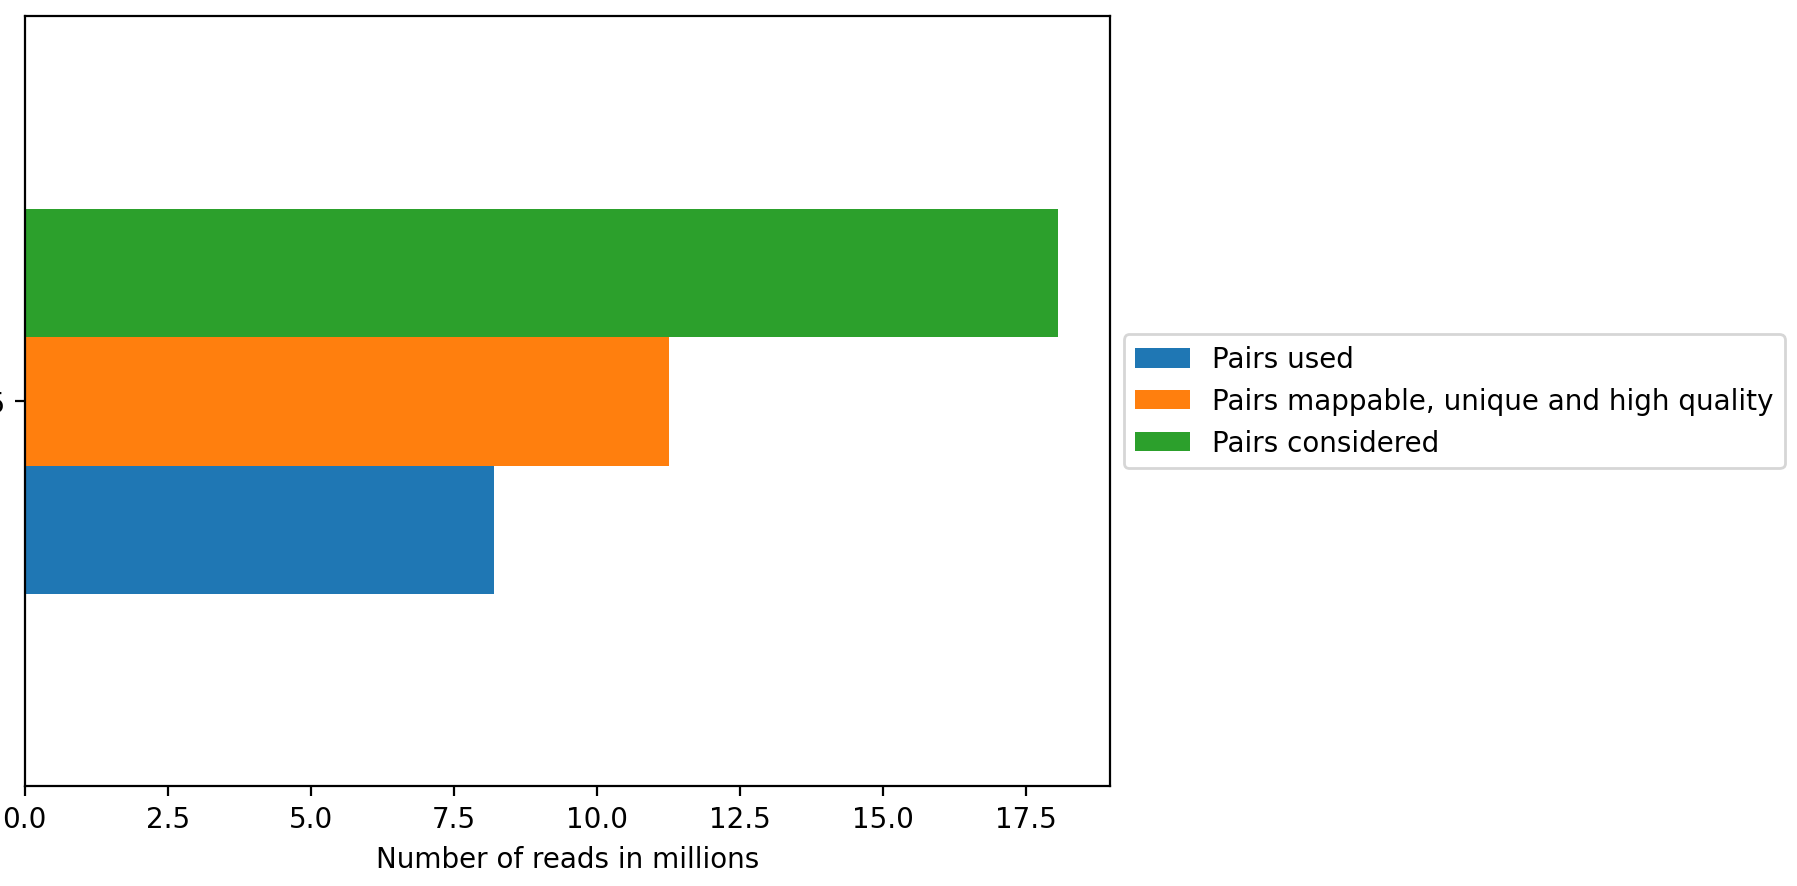

In [22]:
Image("data/build_matrix/SRR5168118_qc/pairs_sequenced.png", width=600)
#　これはvalid-pairの数（コンタクトマップの計算に実際に使われるペア）   
#　もともと1,750万ペアほどあったのが、800万ペアほどに減っている。

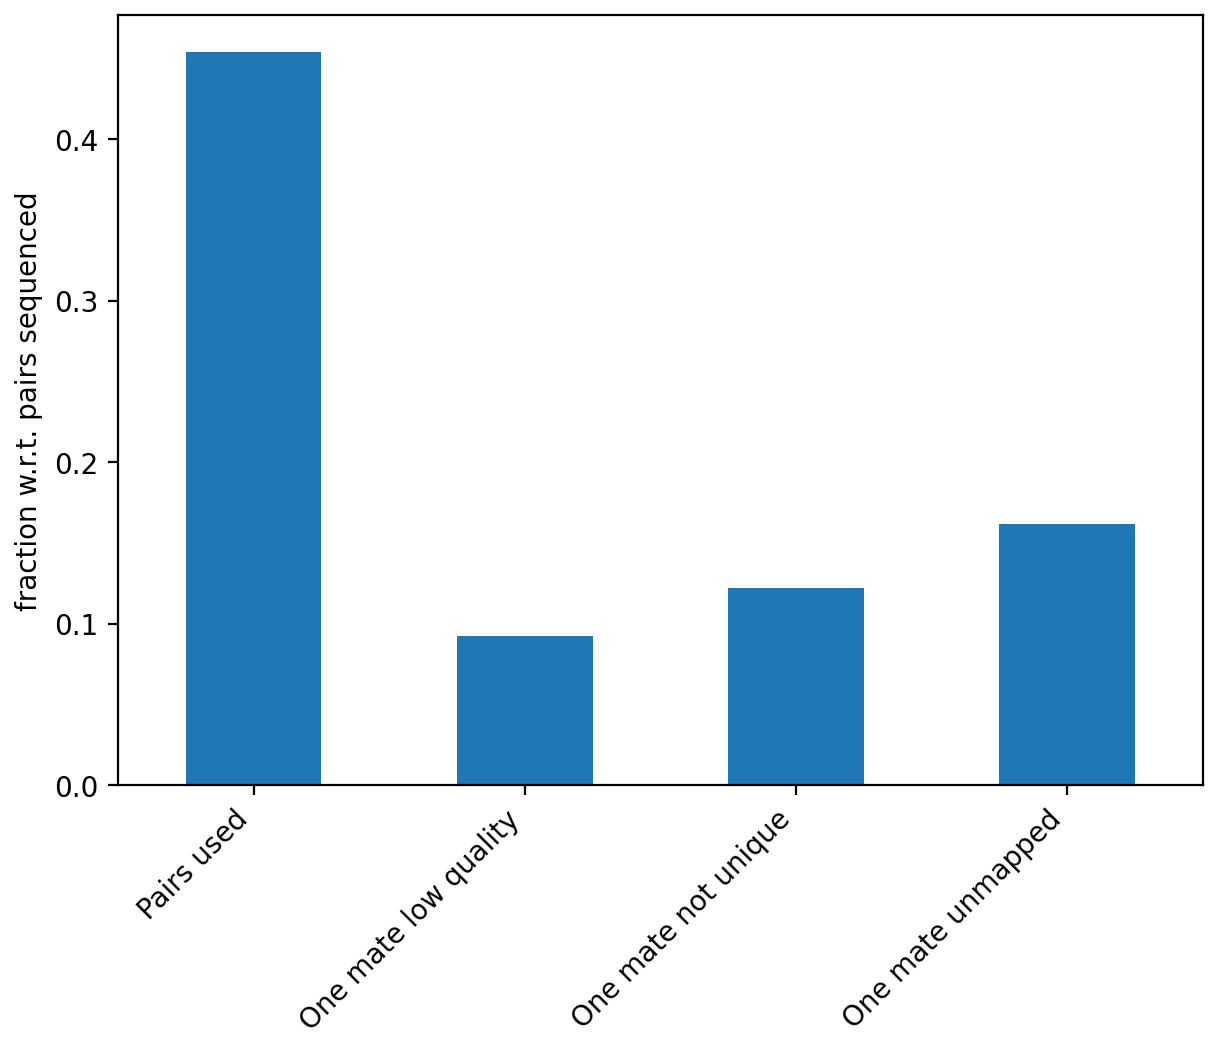

In [23]:
Image("data/build_matrix/SRR5168118_qc/unmappable_and_non_unique.png", width=600)
#　全部のペアに対する、マッピングのクオリティなどで基準を通過したペアの割合。

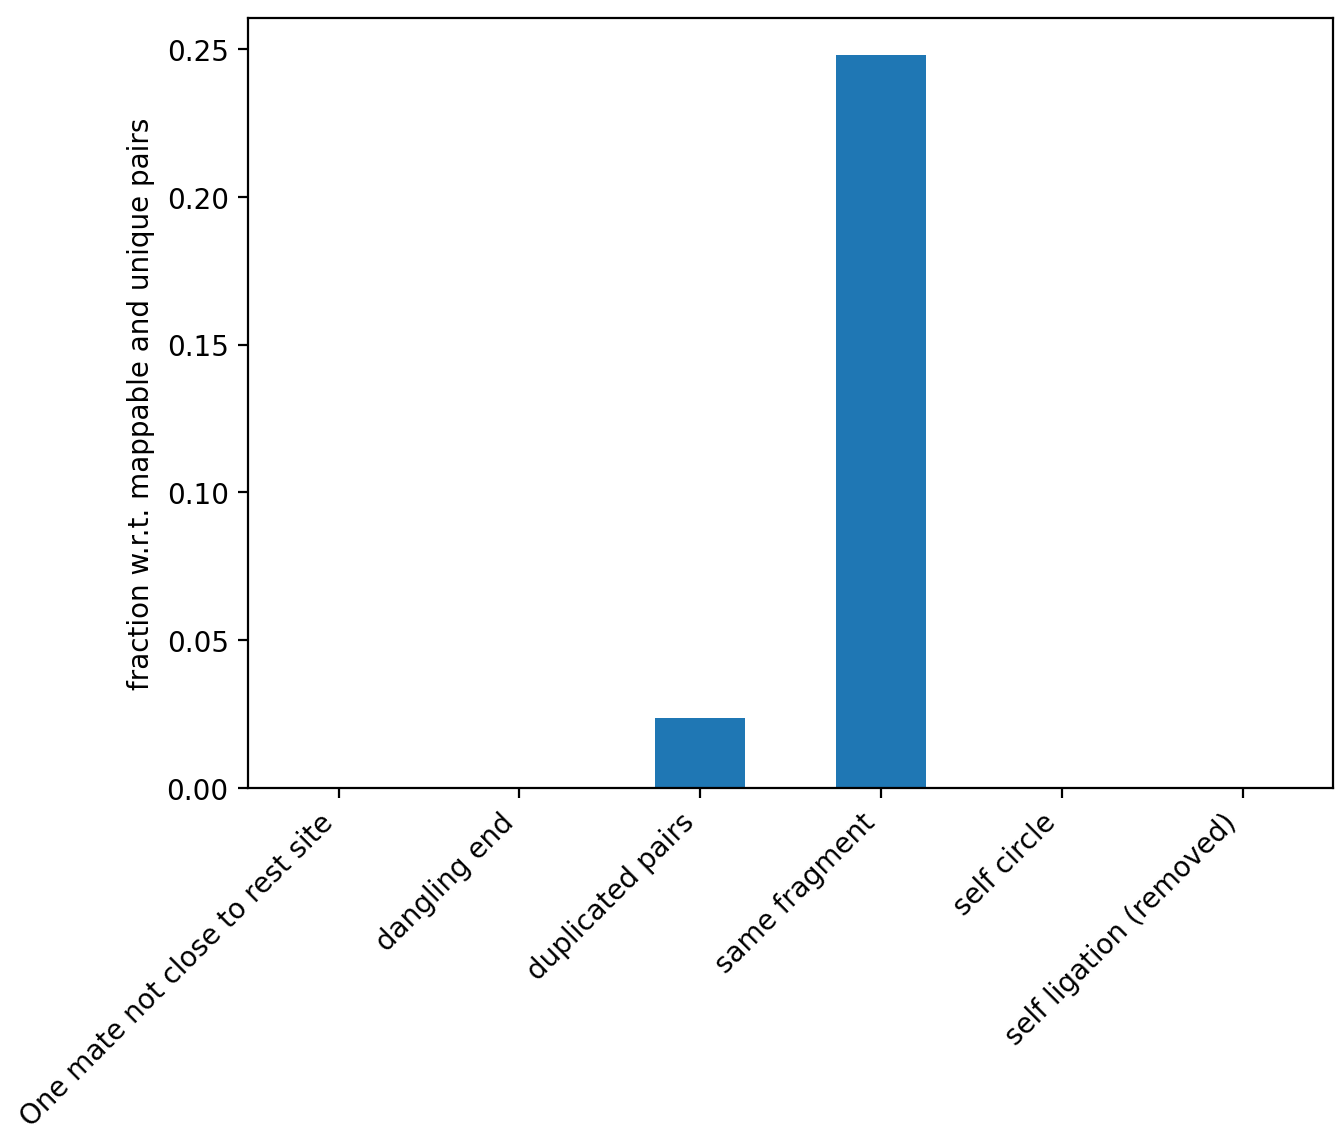

In [25]:
Image("data/build_matrix/SRR5168118_qc/pairs_discarded.png", width=600)
#　mappable pairsのうち、「コンタクト」を反映しないダメなペアの割合。これらは除去される。
#+ dangling ends: 制限消化された部位からはじまるリード。ligationに失敗してるやつ。
#+ duplicated pairs: 同じ位置にマッピングされるペア。PCR増幅の疑い
#+ same fragment: 800bp以内の距離で →　← の方向でマッピングされるペア。同じ制限断片に由来
#+ self circle: 25kbp以内の距離で ←　→ の方向でマッピングされるペア。自己環状化断片の疑い。
#+ self ligation: same fragmentと同じだが、内部に制限酵素認識サイトあり。同じ位置で開いて閉じたやつ。

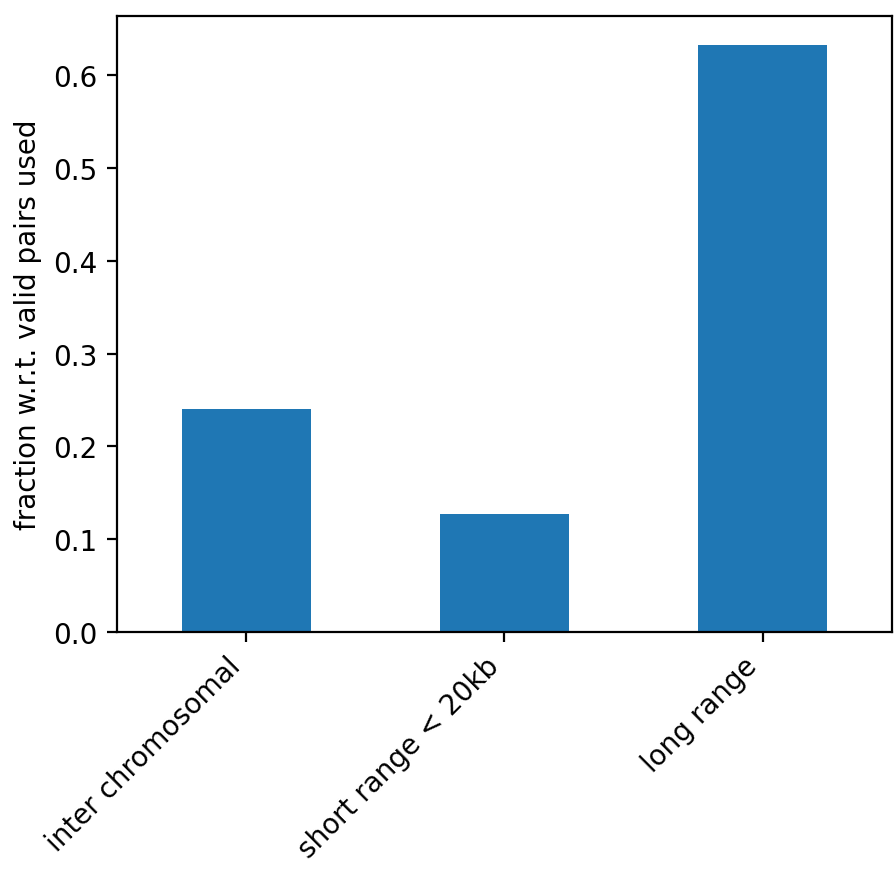

In [26]:
Image("data/build_matrix/SRR5168118_qc/distance.png", width=600)
#  最終的にコンタクトマップに集計された「コンタクト」の位置関係。  
#  この図はQCとして重要な情報を含む。  
#  Hi-C実験、うまくいってないと、異常に高い "inter-chromosomal contact" （異なる染色体間のコンタクト）割合が観測されることがある。（構造が壊れて染色体間の接触がランダムに観測される）    
#  このサンプルの場合は、25%程度なのでまあまあ普通のクオリティ。  

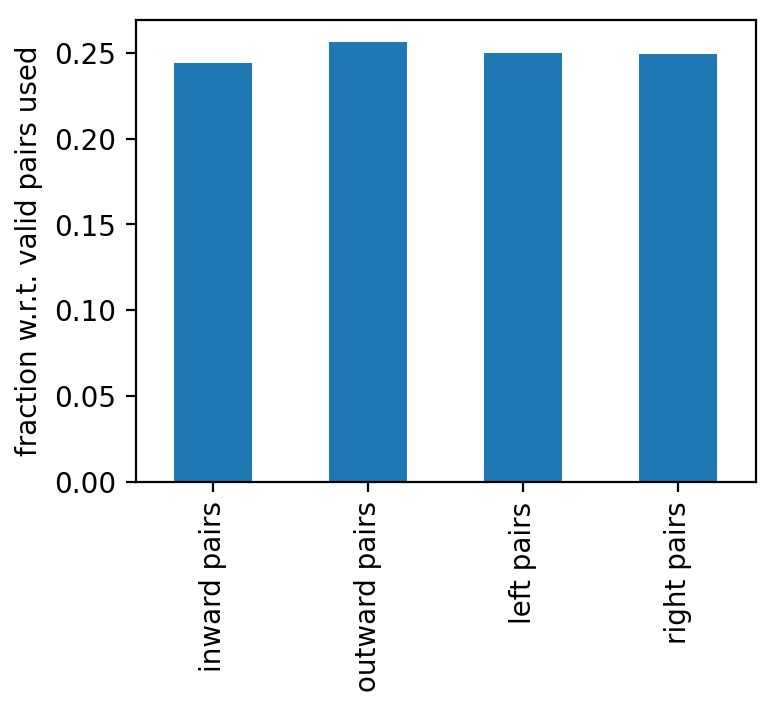

In [27]:
Image("data/build_matrix/SRR5168118_qc/read_orientation.png", width=600)
#　最終的にコンタクトマップに集計されたペアリードのマッピングの方向。  
#　→←、←→、←←、→→の4パターン。  
#　ちゃんと網羅的に接触がとれてるなら4パターンの割合に偏りはないはず。  
#　どれかが極端に多い・少ない場合は注意が必要。  

## 4. コンタクトマップの正規化

RNA-seqやメタゲノムなど「一次元データ」の正規化とは異なり、Hi-C解析の場合は二次元データに適した正規化手法を適用する必要がある。  
よく使われるのは ICE法（[Imakaev, Maxim, et al. "Iterative correction of Hi-C data reveals hallmarks of chromosome organization." Nature methods 9.10 (2012): 999.](https://www.nature.com/articles/nmeth.2148)）で、matrix balancingと呼ばれる数学的手法の一種。  

より高速なmatrix balancingの手法として、[Knight-Ruiz法](https://pdfs.semanticscholar.org/4f5d/26b58c3ad6697bada5553496c62fc2a91295.pdf)もよく使われる。  

In [ ]:
%%bash
datadir=data/build_matrix
outdir=data/correct_matrix
for srr_id in "SRR5168118" "SRR5168150"
do
    echo $srr_id
    matrixfile=${datadir}/${srr_id}_100kb.h5
    outfile=${outdir}/${srr_id}_100kb_diagnostic_plot.png
    hicCorrectMatrix diagnostic_plot \
        --matrix ${matrixfile} \
        --plotName ${outfile}
done

In [ ]:
Image("data/correct_matrix/SRR5168118_100kb_diagnostic_plot.png", width=600)

In [ ]:
Image("data/correct_matrix/SRR5168150_100kb_diagnostic_plot.png", width=600)

In [ ]:
%%bash
Threshold_SRR5168118="-2.8 3"
Threshold_SRR5168150="-2.0 3"

datadir=data/build_matrix
outdir=data/correct_matrix
for srr_id in "SRR5168118" "SRR5168150"
do
    echo $srr_id
    threshold_variable="Threshold_"$srr_id
    matrixfile=${datadir}/${srr_id}_100kb.h5
    outfile=${outdir}/${srr_id}_100kb_corrected.h5
    hicCorrectMatrix correct \
        --filterThreshold ${!threshold_variable} \
        --matrix ${matrixfile} \
        --outFileName ${outfile}
done

## 5. コンタクトマップの描画

```hicPlotMatrix```コマンドを使って正規化コンタクトマップを描画してみる。  
全体を描画することもできるが、ここでは```--region```オプションで特定の領域だけ。  
```--region chr18```などとすると特定の染色体のみ、さらに```chr18:4000000-30000000```などとすることで領域を指定できる。

In [30]:
%%bash
datadir=data/correct_matrix
outdir=data/plot_matrix

for srr_id in "SRR5168118" "SRR5168150"
do
    echo $srr_id
    matrixfile=${datadir}/${srr_id}_100kb_corrected.h5
    outfile=${outdir}/${srr_id}_plot.png
    hicPlotMatrix \
        --matrix ${matrixfile} \
        --outFileName ${outfile} \
        --log1p --dpi 300 \
        --region chr18:4000000-30000000
done

SRR5168118
SRR5168150


/usr/local/lib/python3.6/site-packages/cooler/fileops.py:103: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(filepath) as f:
INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: False
INFO:hicexplorer.hicPlotMatrix:min: 4.001709066785141e-05, max: 552.6274265605119

/usr/local/lib/python3.6/site-packages/cooler/fileops.py:103: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


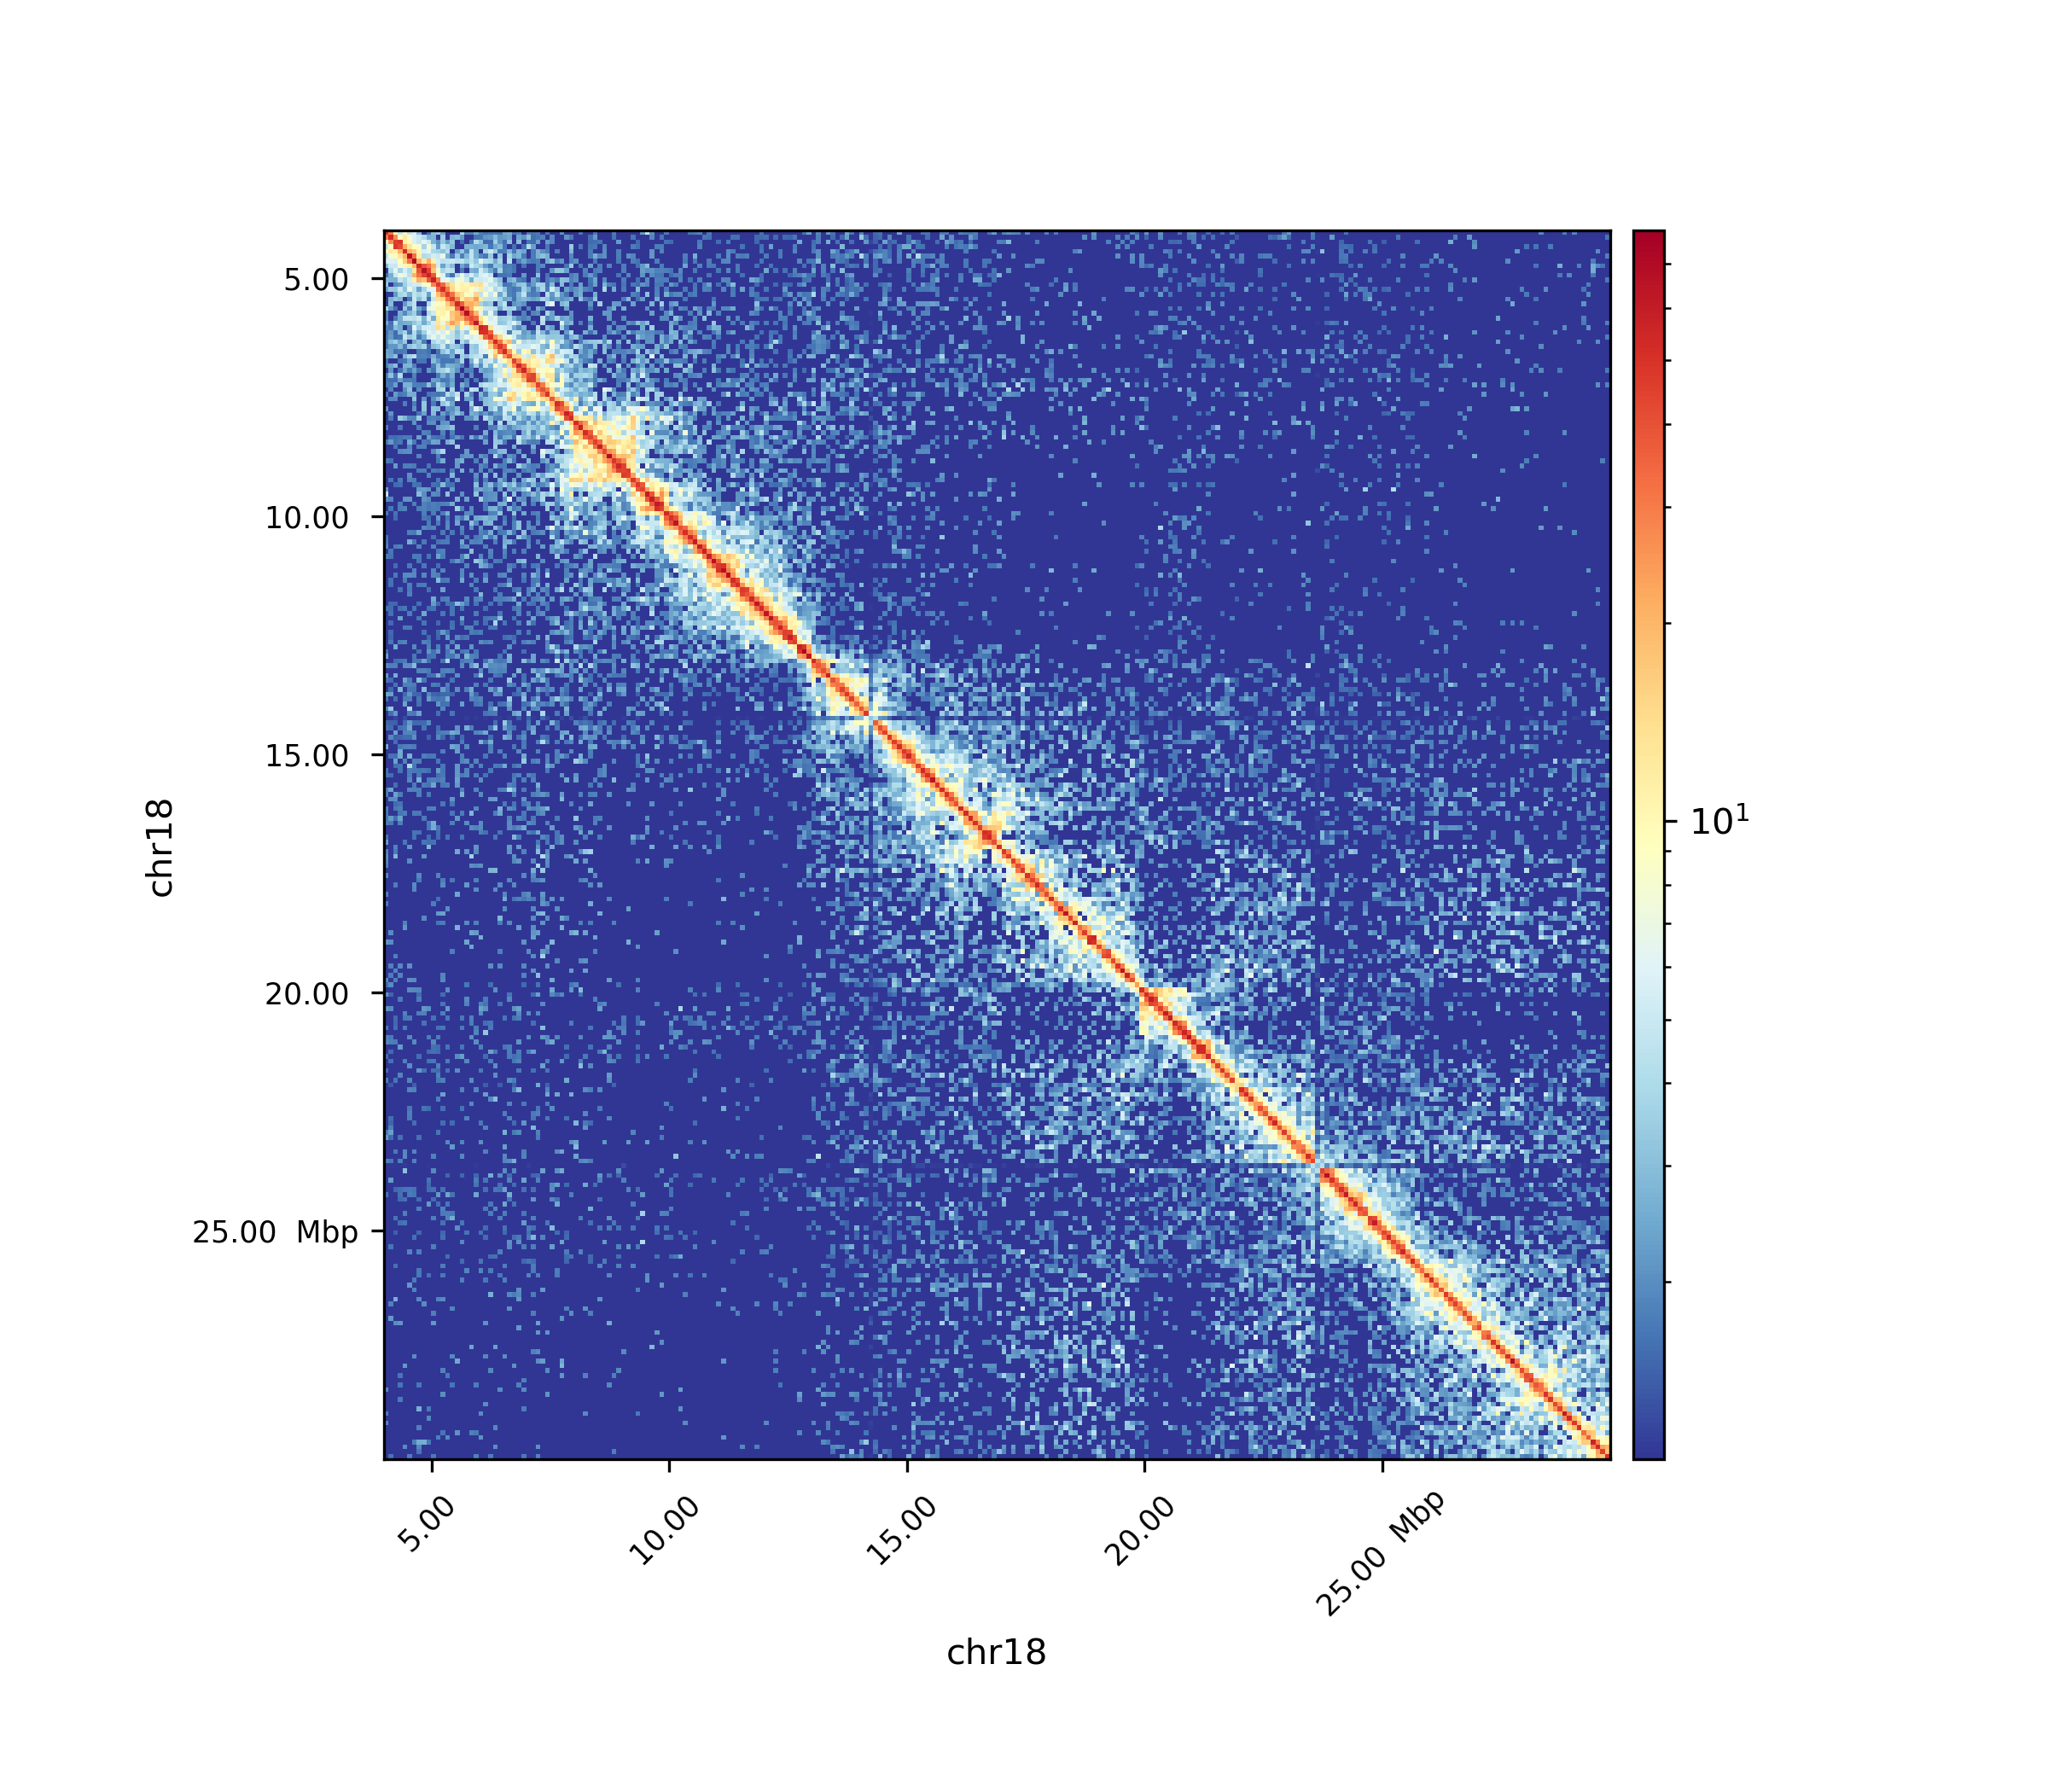

In [31]:
Image("data/plot_matrix/SRR5168118_plot.png", width=600)
#  WTサンプル、chr18の40,000,0000-30,000,000の領域。

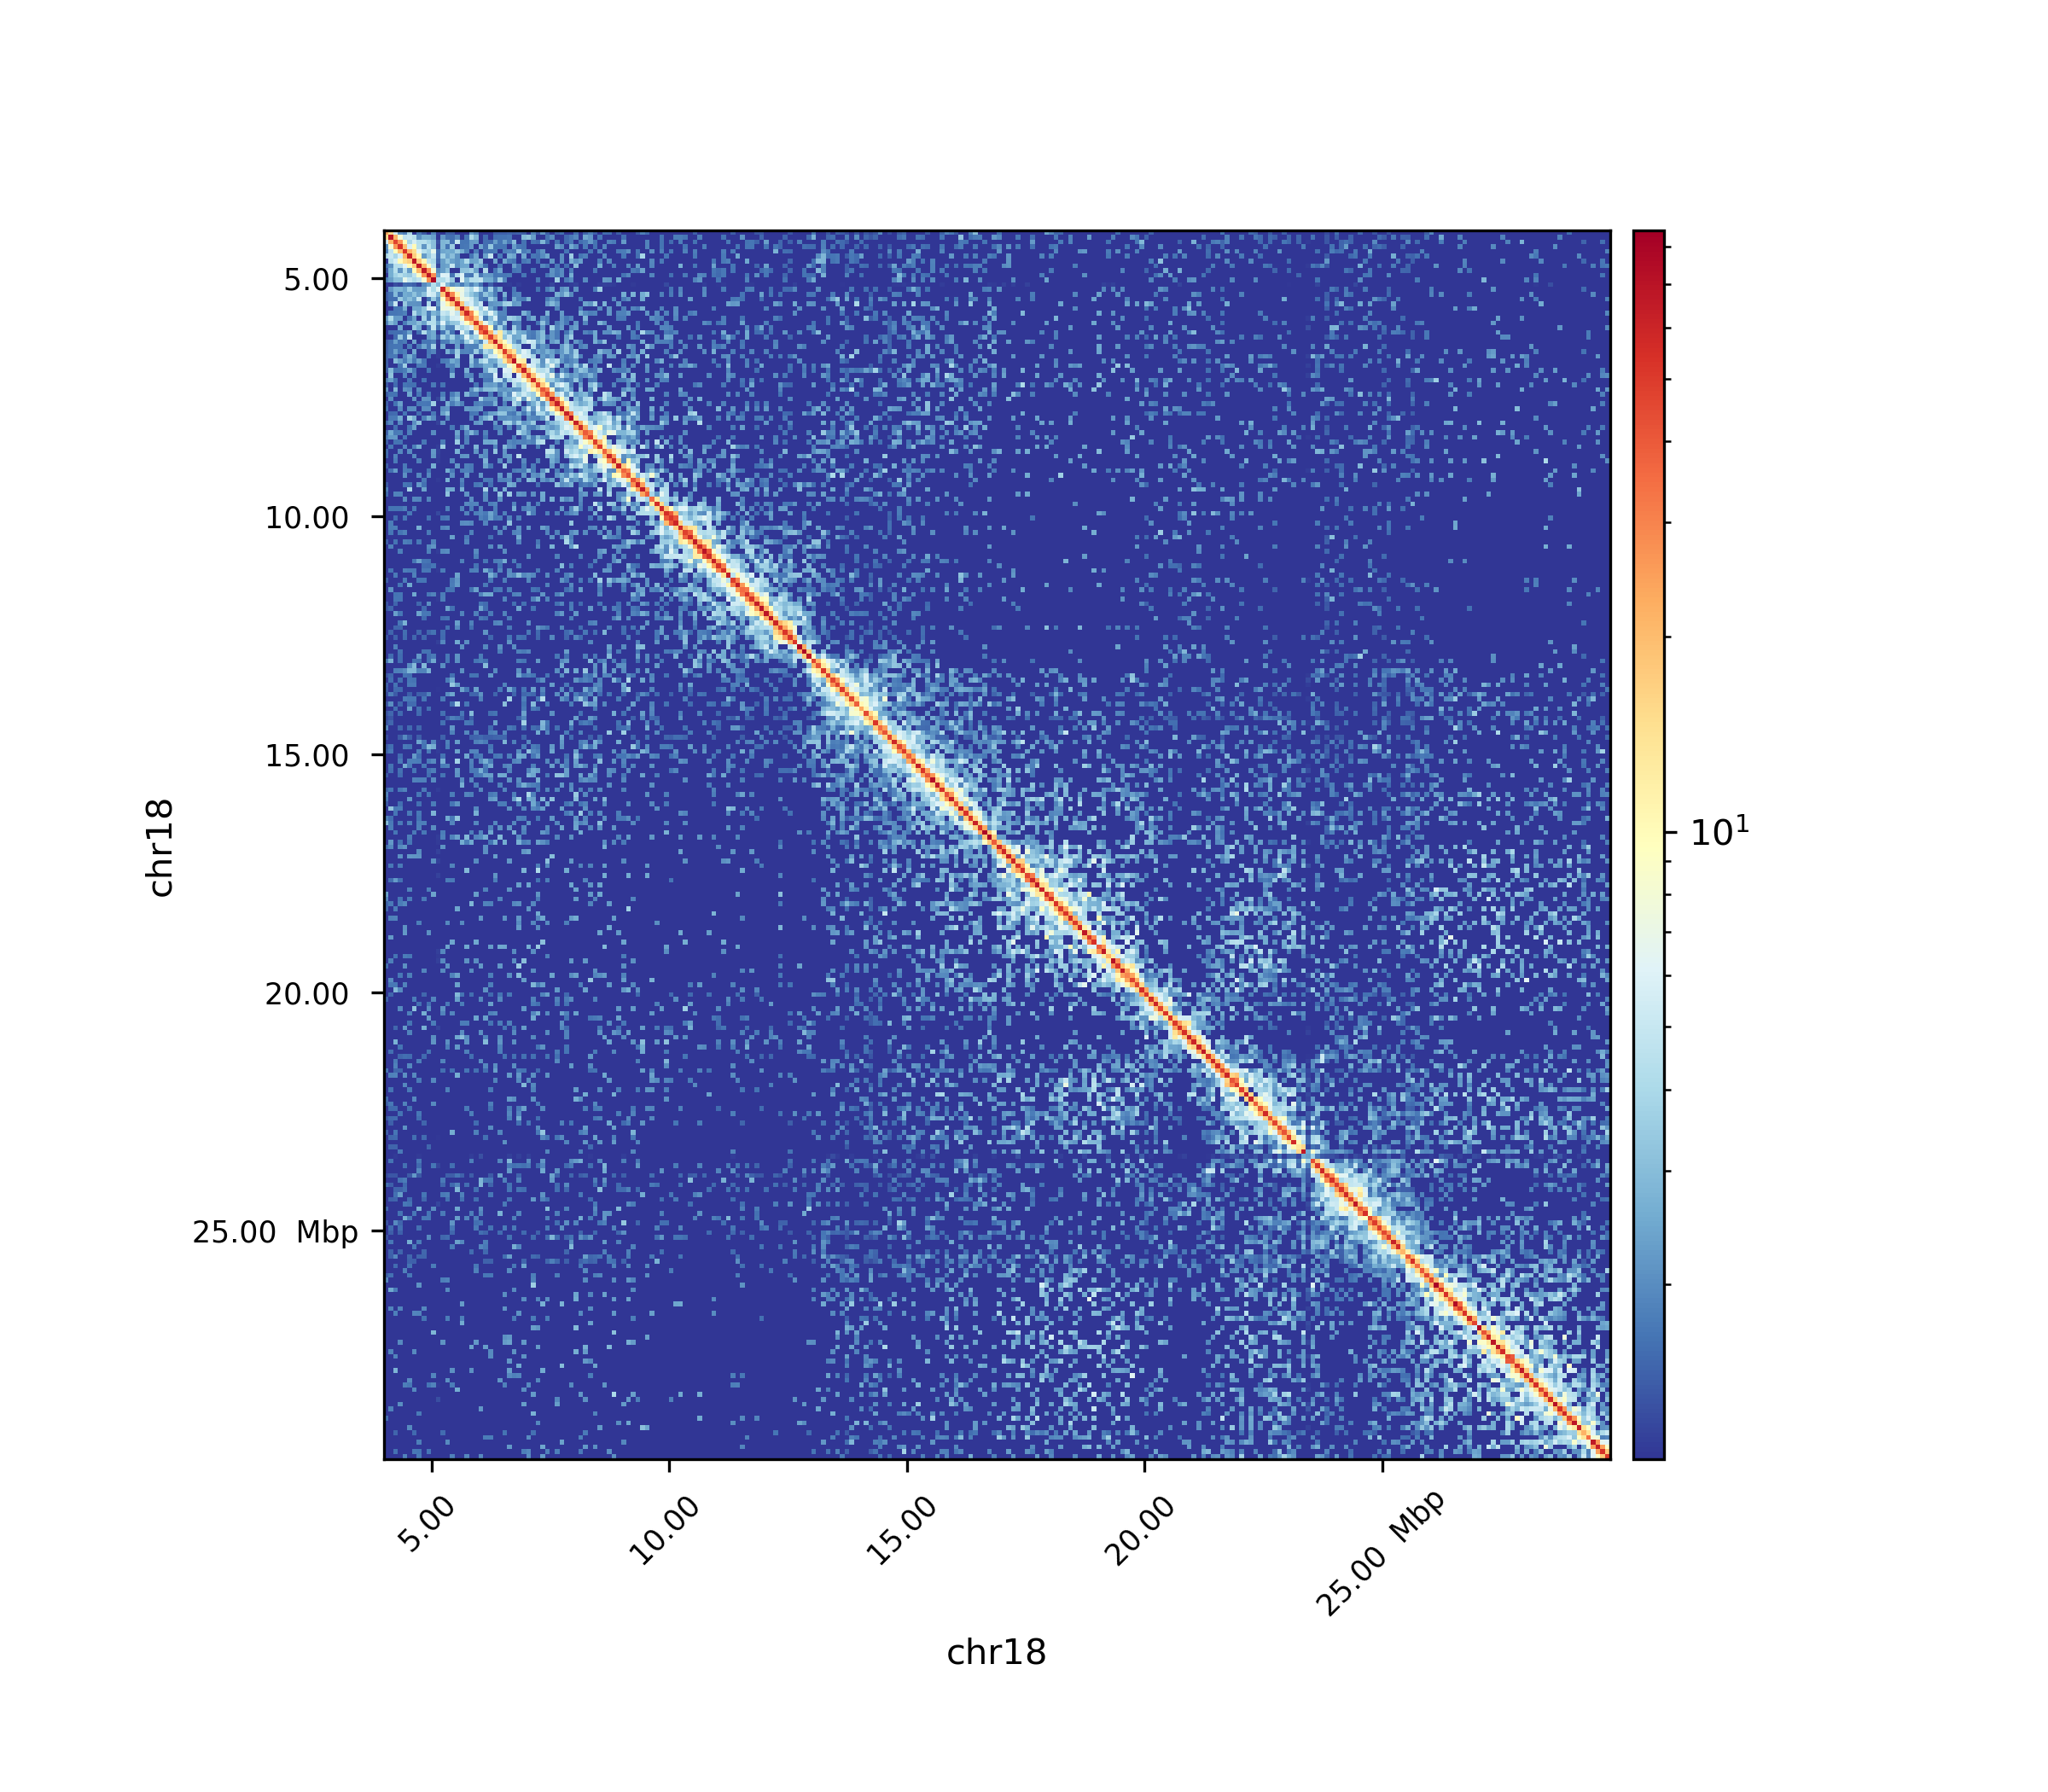

In [32]:
Image("data/plot_matrix/SRR5168150_plot.png", width=600)
#　ΔNipblサンプル、chr18の40,000,0000-30,000,000の領域。   
#　あまりWTと差がないように見えるかもしれないけど、よく見ると、対角線のラインの周辺で色が薄い。   
#　数百kbp~数Mbpくらいの距離のコンタクトが少ない傾向にあることがわかる。

実際に、ゲノム配列上の「距離」と「コンタクト」との関係を見てみる。  
これも、Hi-C関連の論文でよく見る図。コンタクトマップの各行について、対角線上（自分のゲノム座標）から左右に離れるとどの程度コンタクトが減衰するかを平均した図。  
HiCExplorerでは、```hicPlotDistVsCounts```コマンドで計算できる。```--maxdepth```オプションで、どれだけ遠くまで見るかを調整する。

In [33]:
%%bash
datadir=data/correct_matrix
data1=${datadir}/SRR5168118_100kb_corrected.h5
data2=${datadir}/SRR5168150_100kb_corrected.h5
outdir=data/plot_matrix
hicPlotDistVsCounts \
    --matrices ${data1} ${data2} \
    --plotFile ${outdir}/dist_count.png \
    --labels 'WT' 'NIPBL' \
    --maxdepth 20000000 \
    --plotsize 5 4.2

INFO:hicexplorer.hicPlotDistVsCounts:processing chromosome all

INFO:hicexplorer.hicPlotDistVsCounts:processing chromosome all

INFO:hicexplorer.hicPlotDistVsCounts:The scale factors used are: {'data/correct_matrix/SRR5168118_100kb_corrected.h5': 0.8644442712270503, 'data/correct_matrix/SRR5168150_100kb_corrected.h5': 1.0}
/usr/local/lib/python3.6/site-packages/hicexplorer/hicPlotDistVsCounts.py:398: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0, args.maxdepth)


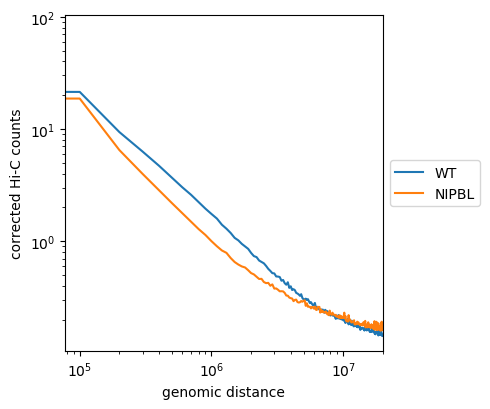

In [34]:
Image("data/plot_matrix/dist_count.png", width=600)
#　WTサンプルとΔNipblサンプル、やっぱり差があることがわかる。  
#　ΔNipblサンプルはコンタクトの減りが速い。

## 6. A/B コンパートメントの計算

次に、ゲノム上のA/B compartmentを計算してみる。  
A/B compartmentは、コンタクトマップを主成分分析することで発見された染色体の「区画」。  
ゲノム上の各Bin（領域）は第一主成分で二極化する傾向がある。それらの2区画が転写活性やオープンクロマチンなどと相関することが知られている。AはAどうしの中で、BはBどうしの中でコンタクトの頻度が高い。  
なので、まずは主成分分析（PCA）をしてみる。使うコマンドは```hicPCA```  

In [1]:
%%bash
<< SKIP #主成分分析はかなりの時間がかかるので省略
datadir=data/correct_matrix
outdir=data/plot_matrix

for srr_id in "SRR5168118" "SRR5168150"
do
    echo $srr_id
    matrixfile=${datadir}/${srr_id}_100kb_corrected.h5
    out_pc1=${outdir}/${srr_id}_pc1.bw
    out_pc2=${outdir}/${srr_id}_pc2.bw
    hicPCA \
        --matrix ${matrixfile} \
        --outputFileName ${out_pc1} ${out_pc2} \
        --format bigwig
done

ゲノム上の各Binの主成分情報がBigWig形式で出てくるので、それらをコンタクトマップと一緒に描画してみる。

In [36]:
%%bash
datadir=data/correct_matrix
outdir=data/plot_matrix

for srr_id in "SRR5168118" "SRR5168150"
do
    echo $srr_id
    matrixfile=${datadir}/${srr_id}_100kb_corrected.h5
    out_pc1=${outdir}/${srr_id}_pc1.bw
    outfile=${outdir}/${srr_id}_pc.png
    hicPlotMatrix \
        --matrix ${matrixfile} \
        --outFileName ${outfile} \
        --log1p --dpi 300 \
        --bigwig ${out_pc1} \
        --region chr13:35000000-60000000
done

SRR5168118
SRR5168150


/usr/local/lib/python3.6/site-packages/cooler/fileops.py:103: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(filepath) as f:
INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: False
INFO:hicexplorer.hicPlotMatrix:min: 4.001709066785141e-05, max: 552.6274265605119

/usr/local/lib/python3.6/site-packages/cooler/fileops.py:103: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


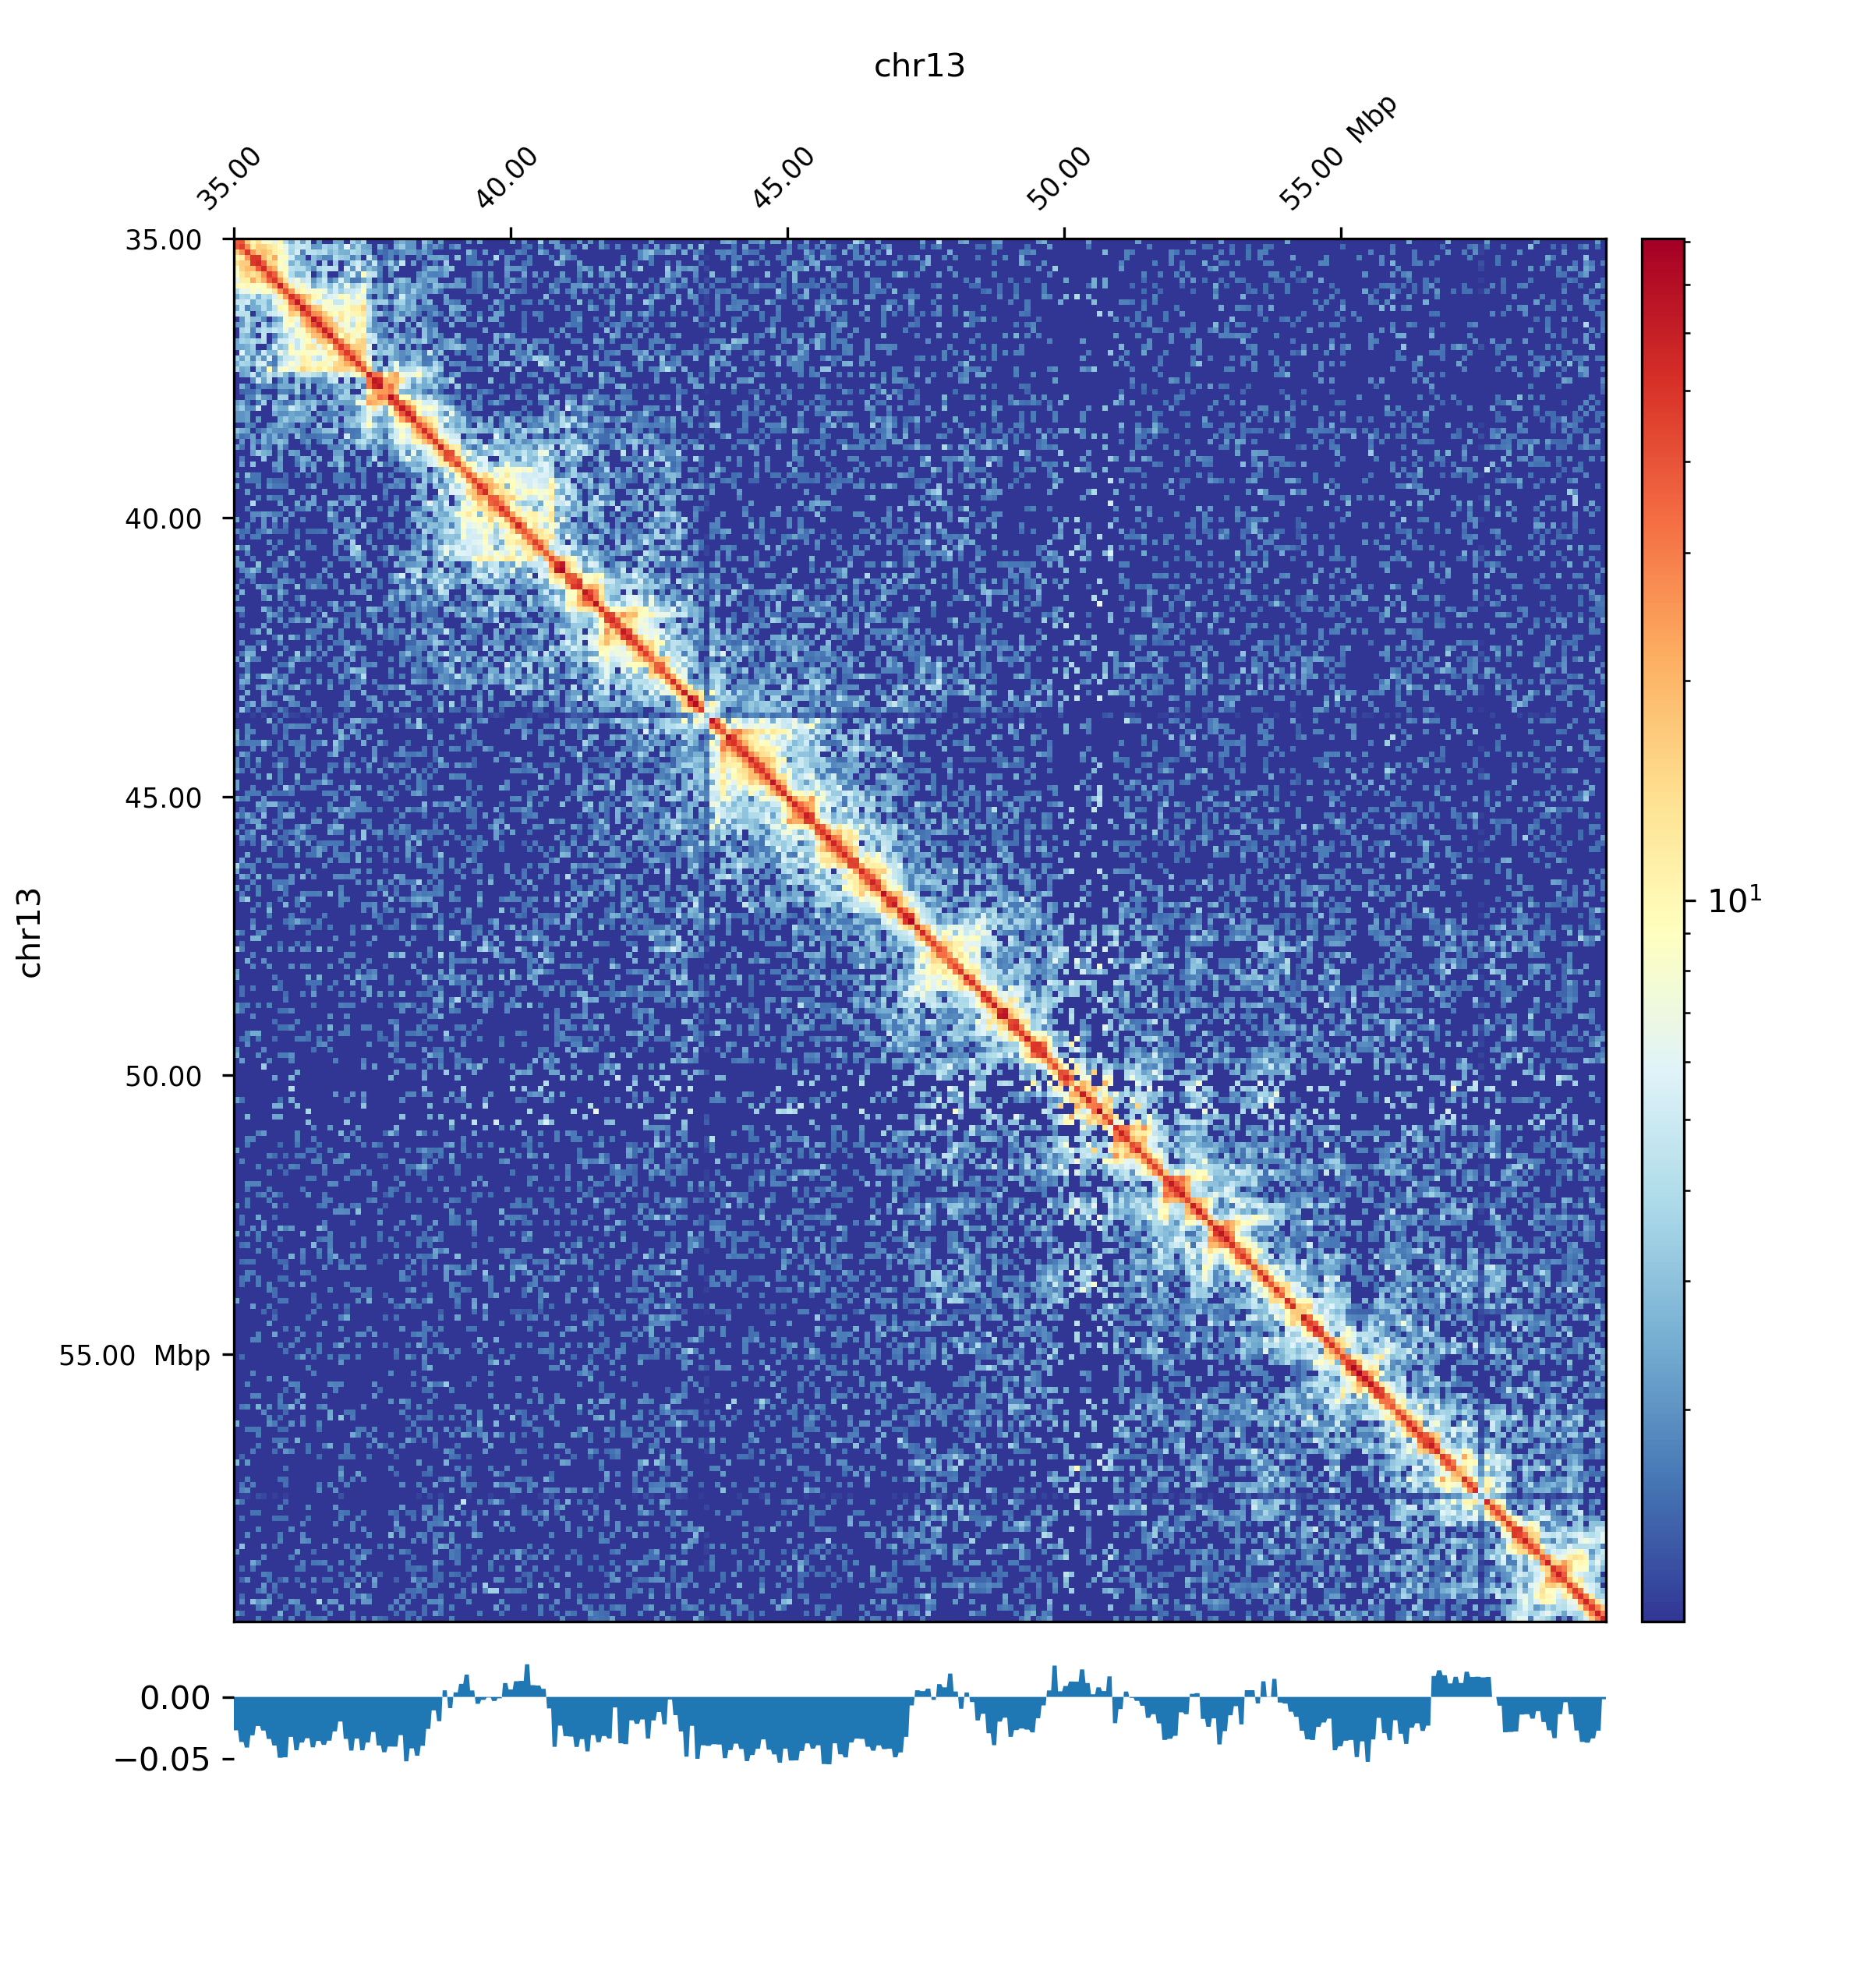

In [37]:
Image("data/plot_matrix/SRR5168118_pc.png", width=600)
#　WTサンプル、chr13:35000000-60000000領域。  
#　Aがプラス・Bがマイナスになるか、逆になるかはデータによって変わる。  
#　なので、二極化しているどっちがA/Bなのかは他のepigenetic marksと相関とるなどして判断する。

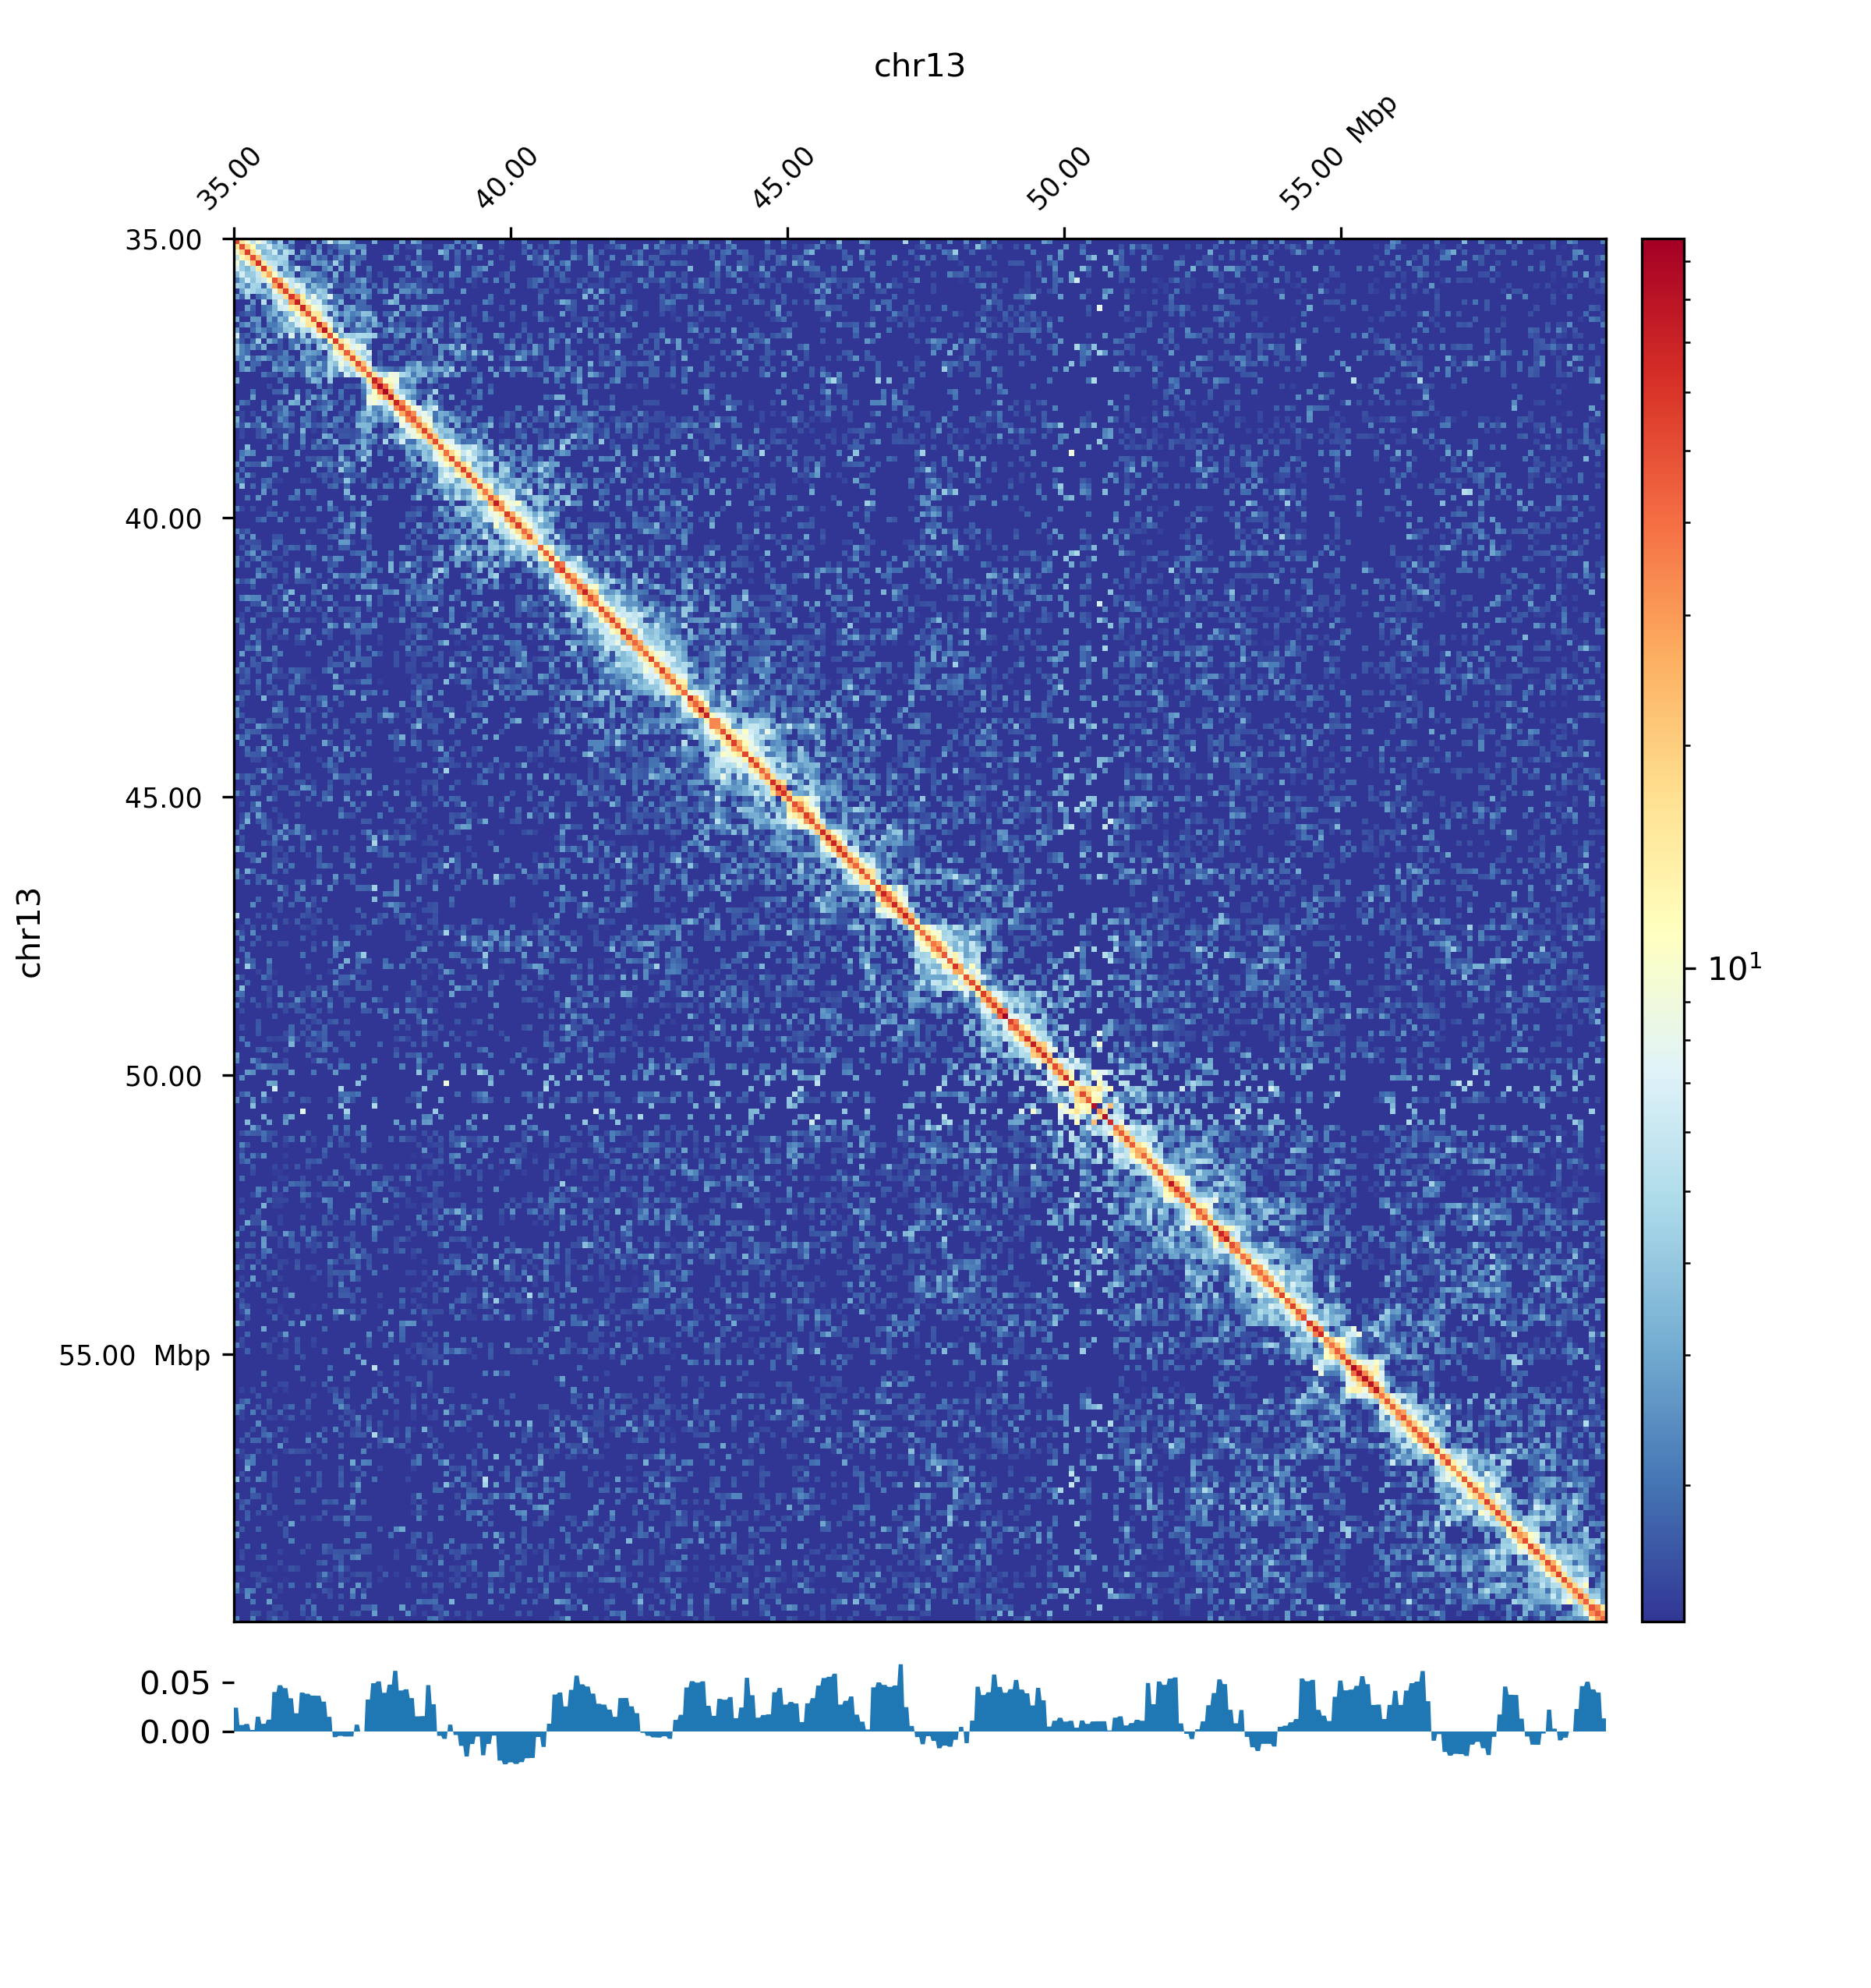

In [38]:
Image("data/plot_matrix/SRR5168150_pc.png", width=600)
#　同じ領域のΔNpiblサンプル。  
#　こっちでは、WTと比較して区画（A/B）が細かい領域で激しく変動しているように見える。  
#　この傾向は、この領域に限らずゲノム全体で観測される。  

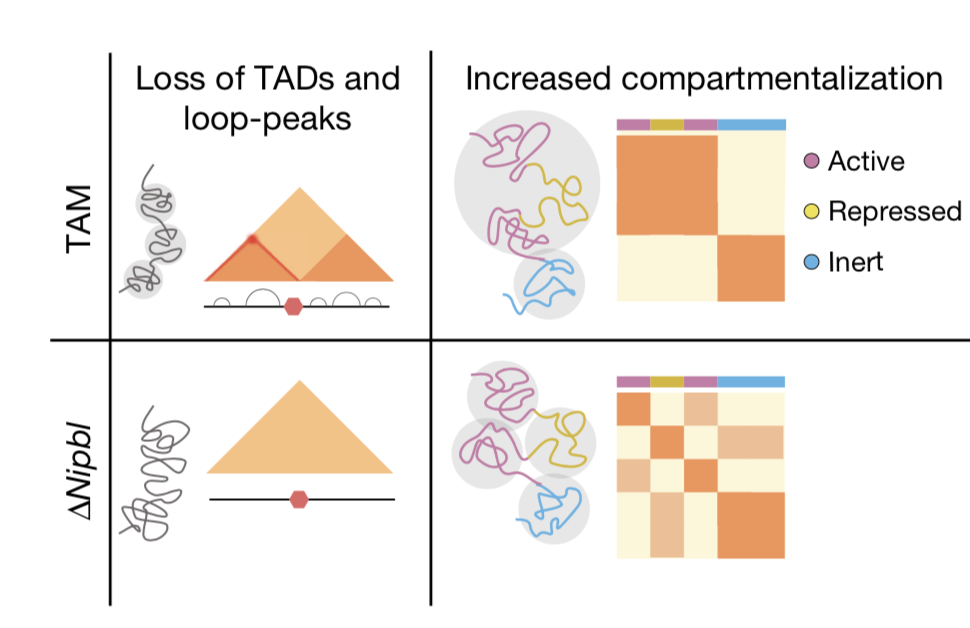

In [39]:
Image("data/images/tad_compartments.png", width=600)
#　解釈は難しいところだけど、Schwarzer2017では、中距離のコンタクトのまとまり（以下で扱うTADs）が消失してしまったぶん、
#（動きの自由度が増して）細かなまとまりが多数できてしまったんじゃないかと考察している。  
 #  ↓Schwarzer2017のFig.5より。

## 7. TADs (Topologically associated domains)の計算

コンタクトマップのデータから、TADを計算してみる。  
アルゴリズムの詳細は講義の方で。  
HiCExplorerでは```hicFindTADs```コマンドで計算。

In [40]:
%%bash
datadir=data/correct_matrix
outdir=data/tads

for srr_id in "SRR5168118" "SRR5168150"
do
    echo $srr_id
    matrixfile=${datadir}/${srr_id}_100kb_corrected.h5
    outfile=${outdir}/${srr_id}
    hicFindTADs \
        --matrix ${matrixfile} \
        --minDepth 300000 --maxDepth 600000 --step 100000 \
        --minBoundaryDistance 400000 \
        --correctForMultipleTesting fdr --threshold 0.05 \
        --outPrefix ${outfile}
done
# --minDepth 300000 --maxDepth 600000 --step 100000 
## z-score変換したコンタクトマップのdiagonal上sliding windowの、
## window size、マルチスケール window sizeの指定。
## コンタクトマップの解像度に合わせて適切に設定する必要がある。

SRR5168118
SRR5168150


INFO:hicexplorer.hicFindTADs:
Found existing TAD-separation score file: data/tads/SRR5168118_tad_score.bm

INFO:hicexplorer.hicFindTADs:This file will be used

INFO:hicexplorer.hicFindTADs:Computing p-values for window length: 300000

INFO:hicexplorer.hicFindTADs:FDR correction. Number of boundaries for delta 0.01, qval 0.05: 1679
INFO:hicexplorer.hicFindTADs:
Found existing TAD-separation score file: data/tads/SRR5168150_tad_score.bm

INFO:hicexplorer.hicFindTADs:This file will be used

INFO:hicexplorer.hicFindTADs:Computing p-values for window length: 300000

INFO:hicexplorer.hicFindTADs:FDR correction. Number of boundaries for delta 0.01, qval 0.05: 996


この計算で、TADの位置を示したBEDファイルなどが生成された。  
あとは、適当なゲノムブラウザなどで見てみたり。  
HiCExplorer使って、コンタクトマップと重ねて描画してみる場合は、```hicPlotTADs```を使う。   
[pyGenomeTracks](https://github.com/deeptools/pyGenomeTracks)を使って描画するので、設定ファイル（tracks.ini）を用意したりしなきゃいけないのが若干めんどくさいけど、すごく自由度が高い描画ツールなので、gene trackと一緒に並べたり、他のepigenetic marksのシーケンスデプスのデータと並べたり、いろいろできる。

In [41]:
! cat ./data/tads/track.ini

[x-axis]
fontsize=10

[hic]
file = data/correct_matrix/SRR5168118_100kb_corrected.h5
title = WT
colormap = Spectral_r
depth = 10000000
min_value = 1
max_value = 100
transform = log1p
x labels = yes
file_type = hic_matrix
show_masked_bins = no

[tads]
file = data/tads/SRR5168118_domains.bed
file_type = domains
border color = black
color = none
height = 5
line width = 1.5
overlay previous = share-y
show data range = no

[spacer]
width = 0.1

[hic]
file = data/correct_matrix/SRR5168150_100kb_corrected.h5
title = NIPBL
colormap = Spectral_r
depth = 10000000
min_value = 1
max_value = 100
transform = log1p
x labels = yes
file_type = hic_matrix
show_masked_bins = no

[tads]
file = data/tads/SRR5168150_domains.bed
file_type = domains
border color = black
color = none
height = 5
line width = 1.5
overlay previous = share-y
show data range = no

In [42]:
%%bash
outfile=./data/tads/tads.png
inifile=./data/tads/track.ini

hicPlotTADs \
    --tracks ${inifile} \
    --region chr12:40000000-70000000 \
    --dpi 300 \
    --outFileName ${outfile}

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:5.997156620025635
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 15.125999999999998. Dpi is set to 300

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [hic]
INFO:pygenometracks.tracks.GenomeTrack:setting min, max values for track 2. [hic] to: 1, 100

INFO:pygenometracks.tracksClass:plotting 3. [tads]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [hic]
INFO:pygenometracks.tracks.GenomeTrack:setting min, max values for track 5. [hic] to: 1, 100

INFO:pygenometracks.tracksClass:plotting 6. [tads]


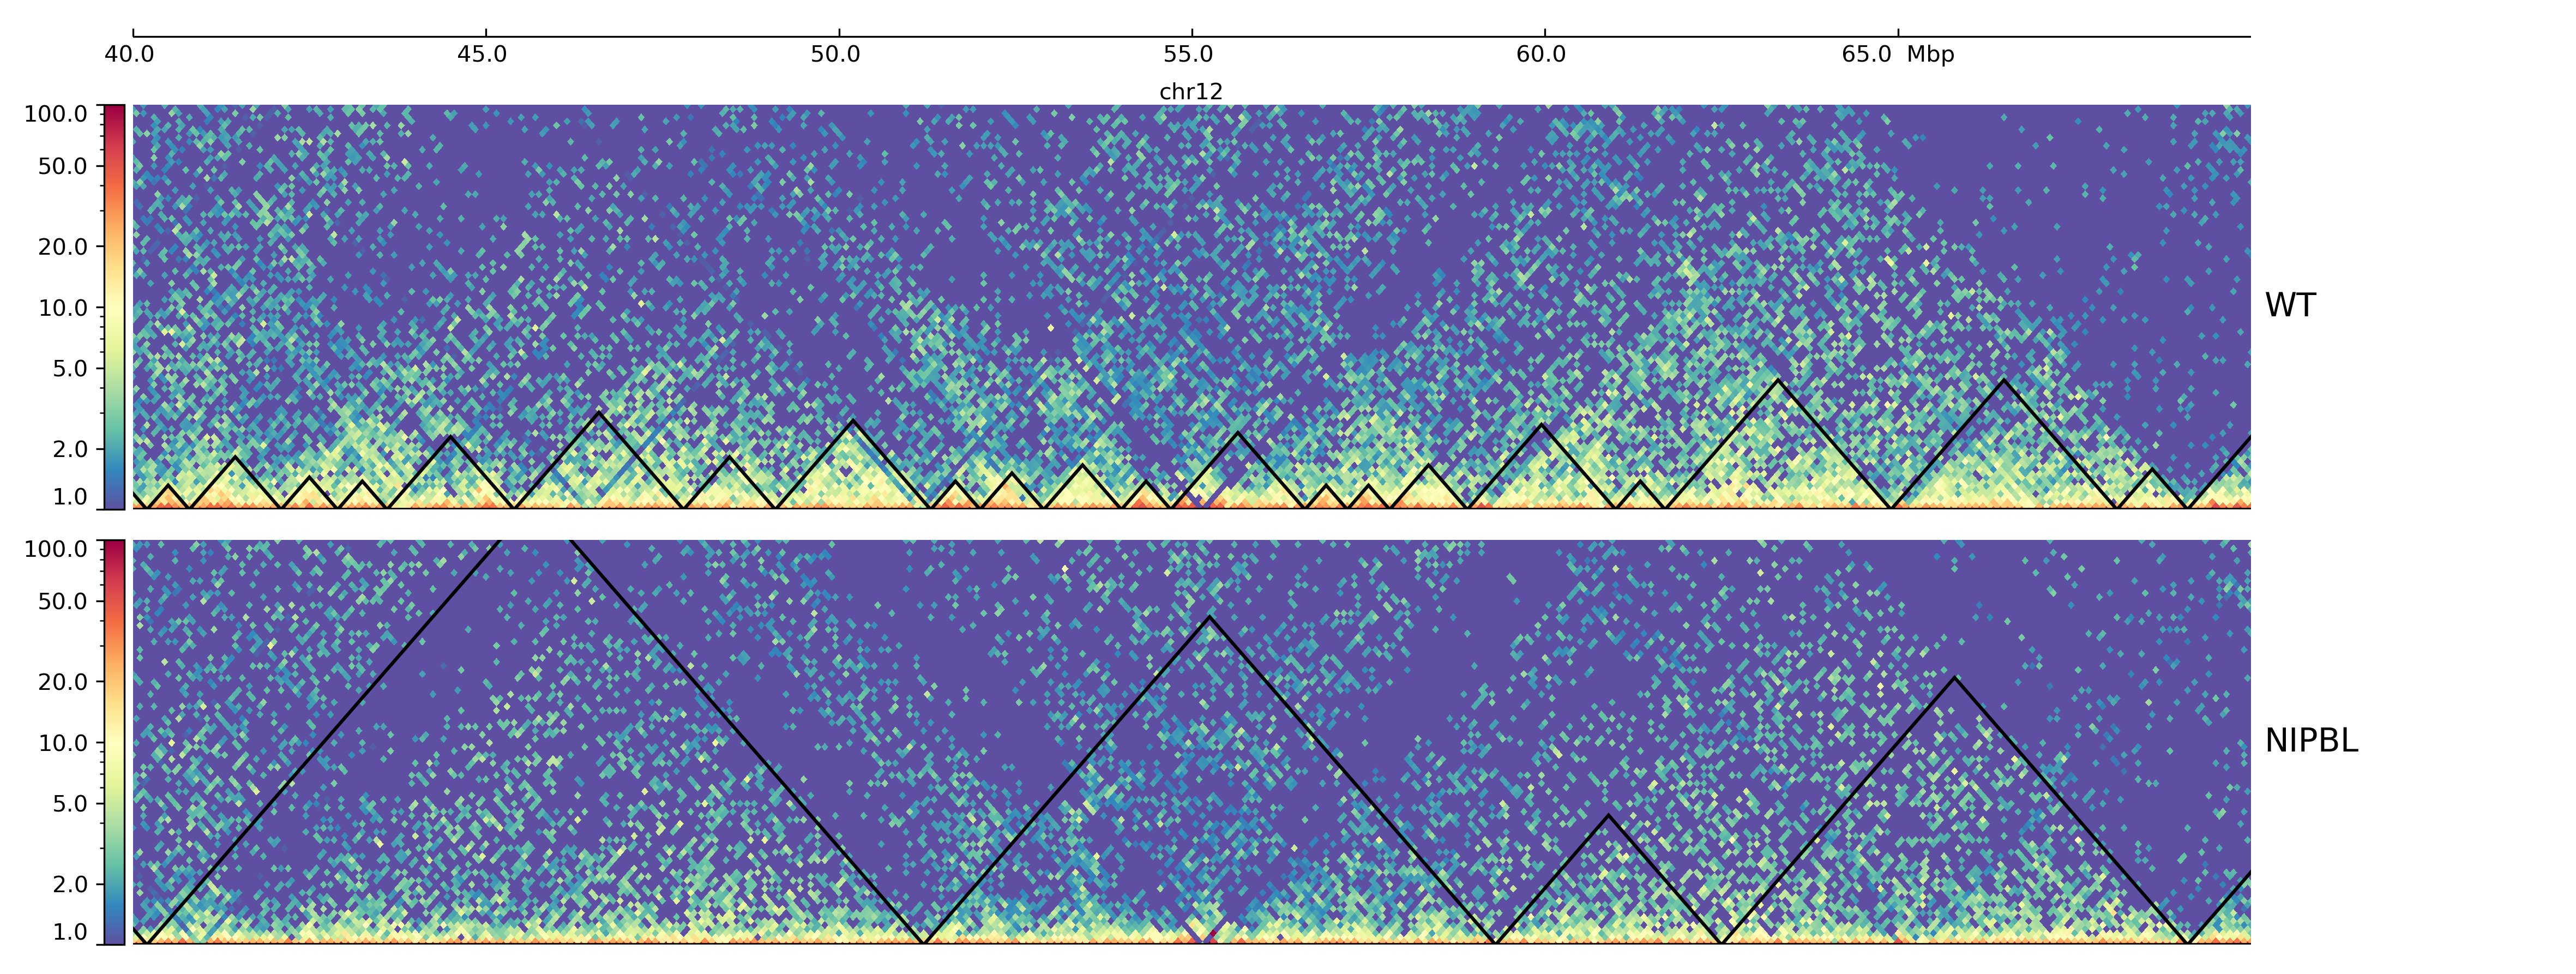

In [43]:
Image("data/tads/tads.png", width=800)

WTサンプルではまともなサイズのTADsがコールされているが、ΔNipblサンプルではそのようなパターンが失われているのがわかる。

## 8. 探索的解析や他のオミックスデータとの比較

正直、興味のある領域が定まっている場合を別として、いちいち領域指定して描画して比較して...みたいなことはやってられない。   
インタラクティブなHi-Cデータビューアを使って、RNA-seqのトラックなどと比較しながら探索することで、構造の変化と機能の変化に気づく、みたいなことがやりたい。   
いろいろなビューアがあるが、[HiGlass](https://github.com/higlass/higlass)がめちゃくちゃおすすめ。  
複数のコンタクトマップの動きをシンクロさせつつ、他のオミックスデータと連携させつつ、快適に探索的データ解析ができる。また、Dockerコンテナを用意してくれてるので、自前でHiGlass描画サーバ起動して快適に計算ができる。      
HiCExplorerで生成したコンタクトマップデータは、```hicConvertFormat```コマンドを使って、Hi-Cデータで広く使われる[cooler形式](https://academic.oup.com/bioinformatics/advance-article/doi/10.1093/bioinformatics/btz540/5530598)に変換できる。また、複数のBinサイズのコンタクトマップを合わせてmulti-resolutionの```.mcool```形式のファイルを生成することもできる。これらのファイルはHiGlassをはじめとした様々なビューアにロードできるので、いろいろと動かしながら、やっぱり最終的には知識を持った研究者が目で見て直感的に判断するのがすごく重要だと思う。